# EV×LA 可視化チェック

Step2/Step3の出力をヒートマップで確認するノートブック。
- 入力: `data/processed/value_map.csv`, `data/processed/bip_with_v_and_y.csv`
- 目的: 高価値帯域の視覚確認と閾値調整のための目視確認


(空セル)


Found 6 players: betts-mookie, judge-aaron, ohtani, schwarber-kyle, soto-juan, trout-mike


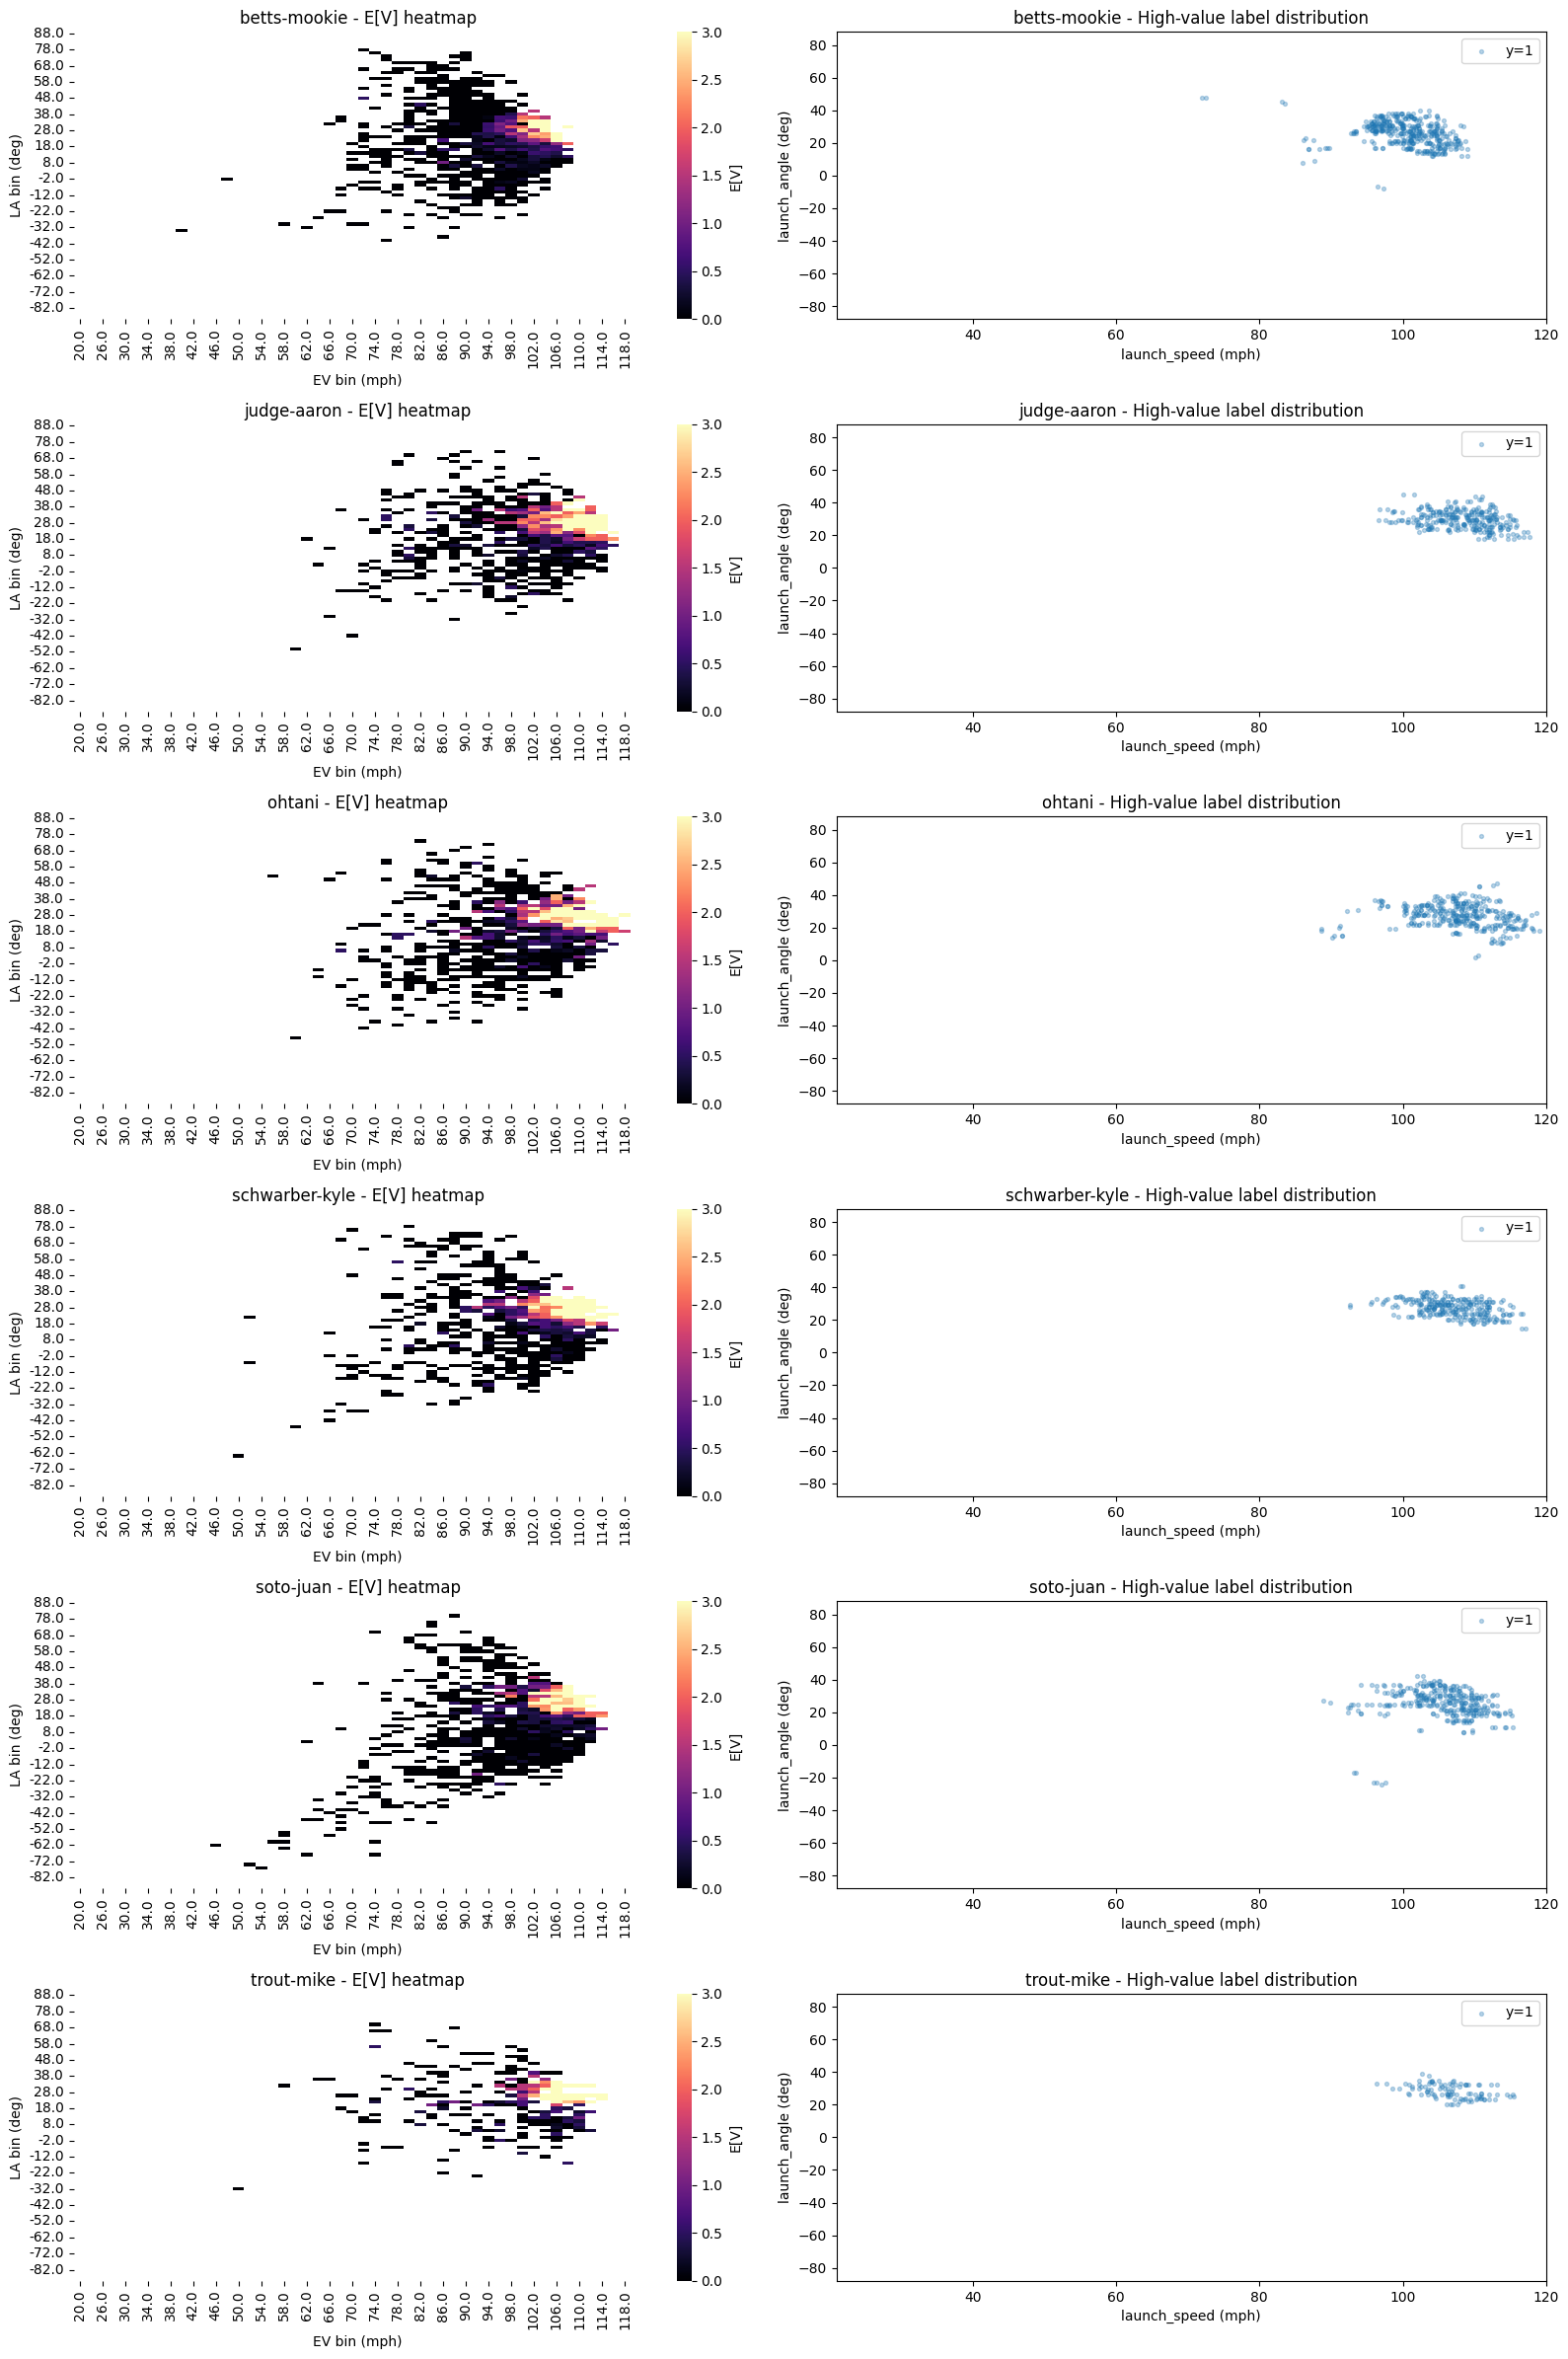

In [5]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

value_map = pd.read_csv("../data/processed/value_map.csv")
bip = pd.read_csv("../data/processed/bip_with_v_and_y.csv")

# 選手別処理か全体処理かを判定
has_player_id = "player_id" in value_map.columns and "player_id" in bip.columns

if has_player_id:
    players = sorted(bip["player_id"].unique())
    print(f"Found {len(players)} players: {', '.join(players)}")
    
    # 全選手の共通軸範囲を計算
    all_la_bins = sorted(value_map["la_bin"].dropna().unique())
    all_ev_bins = sorted(value_map["ev_bin"].dropna().unique())
    la_min, la_max = bip["launch_angle"].min(), bip["launch_angle"].max()
    ev_min, ev_max = bip["launch_speed"].min(), bip["launch_speed"].max()
    
    # 選手別に可視化
    n_players = len(players)
    fig, axes = plt.subplots(n_players, 2, figsize=(16, 4 * n_players))
    if n_players == 1:
        axes = axes.reshape(1, -1)
    
    for idx, player_id in enumerate(players):
        vm_player = value_map[value_map["player_id"] == player_id]
        bip_player = bip[bip["player_id"] == player_id]
        
        # ヒートマップ: E[V]
        vm_pivot = vm_player.pivot(index="la_bin", columns="ev_bin", values="E_V")
        # 全選手共通のla_binとev_binでリインデックス（欠損はNaN）
        vm_pivot_aligned = vm_pivot.reindex(
            index=all_la_bins[::-1],  # 降順
            columns=all_ev_bins
        )
        sns.heatmap(
            vm_pivot_aligned,
            cmap="magma",
            cbar_kws={"label": "E[V]"},
            ax=axes[idx, 0],
            vmin=0,  # 値の範囲も統一（必要に応じて調整）
            vmax=value_map["E_V"].max()
        )
        axes[idx, 0].set_xlabel("EV bin (mph)")
        axes[idx, 0].set_ylabel("LA bin (deg)")
        axes[idx, 0].set_title(f"{player_id} - E[V] heatmap")
        
        # y=1 の分布チェック（散布）
        y1 = bip_player[bip_player["y"] == 1]
        axes[idx, 1].scatter(y1["launch_speed"], y1["launch_angle"], s=8, alpha=0.3, label="y=1")
        axes[idx, 1].set_xlabel("launch_speed (mph)")
        axes[idx, 1].set_ylabel("launch_angle (deg)")
        axes[idx, 1].set_xlim(ev_min, ev_max)  # 横軸統一
        axes[idx, 1].set_ylim(la_min, la_max)  # 縦軸統一
        axes[idx, 1].legend()
        axes[idx, 1].set_title(f"{player_id} - High-value label distribution")
    
    plt.tight_layout()
    plt.show()
    
else:
    # 従来通り全体で可視化
    vm_pivot = value_map.pivot(index="la_bin", columns="ev_bin", values="E_V")
    plt.figure(figsize=(10, 6))
    sns.heatmap(vm_pivot.sort_index(ascending=False), cmap="magma", cbar_kws={"label": "E[V]"})
    plt.xlabel("EV bin (mph)")
    plt.ylabel("LA bin (deg)")
    plt.title("E[V] heatmap")
    plt.show()
    
    # y=1 の分布チェック（散布）
    plt.figure(figsize=(10, 4))
    y1 = bip[bip["y"] == 1]
    plt.scatter(y1["launch_speed"], y1["launch_angle"], s=8, alpha=0.3, label="y=1")
    plt.xlabel("launch_speed (mph)")
    plt.ylabel("launch_angle (deg)")
    plt.legend()
    plt.title("High-value label distribution")
    plt.show()
